In [1]:
import glob
import cv2
import math 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import json
import datetime
import matplotlib.image as mpimg
import random
import time


%matplotlib inline
import pandas as pd
import numpy as np
np.random.bit_generator = np.random._bit_generator

from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten,MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model,load_model
#from keras_segmentation.models.model_utils import get_segmentation_mode
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.contrib import distributions

# from tensorflow.keras.utils import np_utils
from skimage.transform import resize
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [2]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [3]:
def get_img_name(path):
    names = glob.glob(f"{path}*")
    names.sort()
    return names

def img_process(img):
    img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT)) #640x480, 320x240
    return img

def show_seg_on_img(img, mask, alpha=0.5):
    #img = img.astype(np.float64)*255
    #img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    #mask = mask.astype(np.float64)*255
    #mask = cv2.normalize(mask, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    
    img_mask = cv2.addWeighted(mask, alpha, img, 0.5, 0)
    return img_mask 

def compare_img(img1, img2, title1 = 'Image 1', title2 = 'Image 2'):
    #img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    #img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(figsize=(16, 12))
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(img1)
    a.set_title(title1)

    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(img2)

    
def predictions_and_uncetrenty(model, T, img):
    
    # shape: (T, (H, W), C)
    predictions = np.array([model.predict(img) for _ in range(T)])
    
    # shape: ((H, W), C)
    prediction_probabilities = np.mean(predictions, axis=tuple(range(img.ndim-2)))
   
    # shape: (H, W)
    #prediction_variances = np.apply_along_axis(predictive_entropy, axis=2, arr=prediction_probabilities)
    prediction_std = np.std(predictions, axis=tuple(range(img.ndim-2)))
    prediction_mask = (prediction_probabilities==prediction_probabilities.max(axis=2, keepdims=1)).astype(np.uint8)
    prediction_std = prediction_std * prediction_mask
    prediction_std = np.amax(prediction_std, axis=2)
    
    prediction_mean = prediction_probabilities * prediction_mask
    prediction_mean = np.amax(prediction_mean, axis=2)
    return prediction_mask, prediction_mean ,prediction_std

'''
If we are not using image augmentation we need to reduce the channels.
'''
def labels_to_maskes_reduce(img_label, color_id_map, num_channels):
    num_objects = len(color_id_map.keys())
    
    height = img_label.shape[0]
    width = img_label.shape[1]

    channels = np.zeros((height, width, num_channels), dtype=np.uint8)
    
    for key, value in color_id_map.items():
        mask = (img_label == value[1]).all(-1)

        channels[..., value[0]] = np.logical_or(channels[:,:, value[0]], mask)


    return channels

def maskes_to_labels(maskes):
    #denne maa muligens fjernes
    maskes = (maskes==maskes.max(axis=2, keepdims=1)).astype(np.uint8)
    labels = np.zeros((maskes.shape[0], maskes.shape[1], 3), dtype=np.uint8)
        
    for key, value in classes_cc.items():
        mask = maskes[..., key]
        labels = labels + mask[..., None] * value
    
    return labels 

def predictions_and_uncetrenty(model, T, img):
    
    # shape: (T, (H, W), C)
    predictions = np.array([model.predict(img) for _ in range(T)])
    
    # shape: ((H, W), C)
    prediction_probabilities = np.mean(predictions, axis=tuple(range(img.ndim-2)))
   
    # shape: (H, W)
    #prediction_variances = np.apply_along_axis(predictive_entropy, axis=2, arr=prediction_probabilities)
    prediction_std = np.std(predictions, axis=tuple(range(img.ndim-2)))
    prediction_mask = (prediction_probabilities==prediction_probabilities.max(axis=2, keepdims=1)).astype(np.uint8)
    prediction_std = prediction_std * prediction_mask
    prediction_std = np.amax(prediction_std, axis=2)
    
    prediction_mean = prediction_probabilities * prediction_mask
    prediction_mean = np.amax(prediction_mean, axis=2)
    return prediction_mask, prediction_mean ,prediction_std

In [4]:
def batch_generator(image_paths, label_path, color_labels, index_list, batch_size, index=0):
    
    
    index = index
    label_path_list = label_path
    image_paths_list = image_paths

    while True:
        
        images = []
        #drivable_area = np.array([])#np.ndarray(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_SEG))
        maskes = []
        data_size = len(index_list)
        
        for i in range(batch_size):
            
            #image_id = images_ids.sample()
            
            index += 1
            if index >= data_size:
                index = 0
             
            #index = random.randint(0, data_size)
            img_url = image_paths_list[index_list[index]]
            label_url = label_path_list[index_list[index]]
            
            img = cv2.imread(img_url)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(label_url)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            
            img = img_process(img)
            mask = img_process(mask)

            mask = labels_to_maskes_reduce(mask, color_labels, NUM_SEG)
            
            images.append(img)
            maskes.append(mask) #.tolist()
            #drivable_area = np.append(drivable_area, rb_img, axis=0)

        yield (np.asarray(images), np.asarray(maskes)) # drivable_area

In [5]:
color_label_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/labels/'

image_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/images/'



classes_cc = { #cc = carla cityScape
    0: [0, 0, 0],        # None
    1: [70, 70, 70],     # Buildings
    2: [190, 153, 153],  # Fences
    3: [72, 0, 90],      # Other
    4: [220, 20, 60],    # Pedestrians
    5: [153, 153, 153],  # Poles
    6: [157, 234, 50],   # RoadLines
    7: [128, 64, 128],   # Roads
    8: [244, 35, 232],   # Sidewalks
    9: [107, 142, 35],   # Vegetation
    10: [0, 0, 255],     # Vehicles
    11: [102, 102, 156], # Walls
    12: [220, 220, 0]    # TrafficSigns
}

#Create dictonary for id to new id, add color for each id later. 
color_id_map = {
       0: [3], 
       1: [3], 
       2: [8],
       3: [2],
       4: [2],
       5: [3],
       6: [11],
       7: [8], 
       8: [7], 
       9: [8],
       10: [7], 
       11: [8], 
       12: [0], 
       13: [7],
       14: [7], 
       15: [8],
       16: [0], 
       17: [1],
       18: [0], 
       19: [4],
       20: [4],
       21: [10],
       22: [10],
       23: [6],
       24: [6],
       25: [0],
       26: [0],
       27: [0], 
       28: [0], 
       29: [0], 
       30: [9],
       31: [0], 
       32: [3],
       33: [3],
       34: [3],
       35: [3],
       36: [3],
       37: [3],
       38: [3],
       39: [3],
       40: [3],
       41: [7],
       42: [3],
       43: [7],
       44: [5],
       45: [5],
       46: [12],
       47: [5],
       48: [12],
       49: [12],
       50: [12],
       51: [3],
       52: [3],
       53: [3],
       54: [10],
       55: [10],
       56: [10],
       57: [10],
       58: [0], 
       59: [10],
       60: [10],
       61: [10],
       62: [10],
       63: [0],
       64: [0],
       65: [0],        
    }

# read in config file
with open('../data/mapillary-vistas-dataset_public_v1.1/config.json') as config_file:
    config = json.load(config_file)
# in this example we are only interested in the labels
labels = config['labels']

# print labels
print("There are {} labels in the config file".format(len(labels)))
for label_id, label in enumerate(labels):
    color_id_map[label_id].append(label["color"])
    #print("{:>30} ({:2d}): {:<40} has instances: {}".format(label["readable"], label_id, label["name"], label["instances"]))
        

IMG_HEIGHT = 480 #640x480, 320x240, 160x120
IMG_WIDTH = 640
NUM_SEG = 13

color_label_val_list = get_img_name(color_label_val)
img_val_list = get_img_name(image_val)
print(len(color_label_val_list))
print(len(img_val_list))
#_drivable_id.png
#_drivable_color.png

There are 66 labels in the config file
2000
2000


In [6]:
imges, labels = next(batch_generator(img_val_list, color_label_val_list, color_id_map, [30], 1))
label = maskes_to_labels(labels[0]).astype(np.uint8)
img = imges[0]

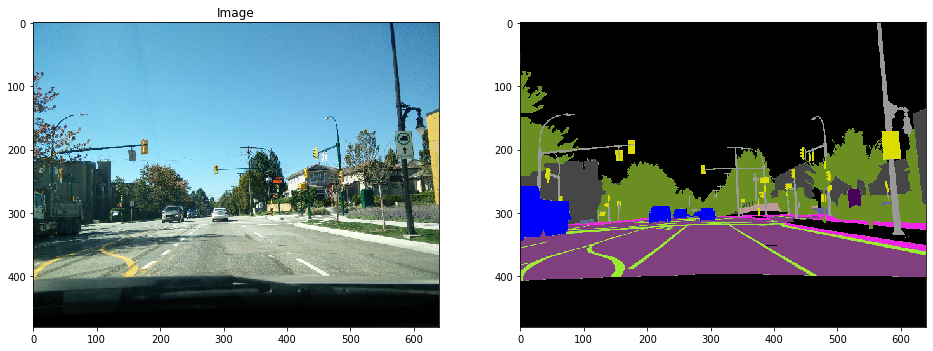

In [7]:
compare_img(img, label, 'Image', 'CityScape labels')


In [8]:
"""
    if True:
        random.seed(0)
        optimizer = Adam(lr=1e-3)
        data_amount = 200
        dropuout_test += 0.05

    with open(json_file_name, "w") as file_write:
    # write json data into file
        json.dump(model_data, file_write)
    file_write.close() 



"""

'\n    if True:\n        random.seed(0)\n        optimizer = Adam(lr=1e-3)\n        data_amount = 200\n        dropuout_test += 0.05\n\n    with open(json_file_name, "w") as file_write:\n    # write json data into file\n        json.dump(model_data, file_write)\n    file_write.close() \n\n\n\n'

In [9]:
with open('model_info.json') as a:
    model_info = json.load(a)


dropout = 0.0
name_dropout = []

for key, value in model_info.items():
    
    print(f'Key: {key}, dropout rate: {value["dropout"]}')
    name_dropout.append([key, value["dropout"]])

    
    
    #value["architecture"] = "u-net"
    #value["data_amount"] = 200
    #dropout += 0.05
    

    
print(f'number of models: {len(name_dropout)}')

Key: u-net_1585114900, dropout rate: 0.17
Key: u-net_1585115750, dropout rate: 0.13
Key: u-net_1585116680, dropout rate: 0.48
Key: u-net_1585118770, dropout rate: 0.45
Key: u-net_1585123137, dropout rate: 0.18
Key: u-net_1585126633, dropout rate: 0.14
Key: u-net_1585130481, dropout rate: 0.42
Key: u-net_1585133766, dropout rate: 0.44
Key: u-net_1585136637, dropout rate: 0.23
Key: u-net_1585145765, dropout rate: 0.28
Key: u-net_1585155175, dropout rate: 0.26
Key: u-net_1585164469, dropout rate: 0.23
Key: u-net_1585201143, dropout rate: 0.21
Key: u-net_1585208398, dropout rate: 0.24
Key: u-net_1585213881, dropout rate: 0.19
Key: u-net_1585227049, dropout rate: 0.27
Key: u-net_1585231644, dropout rate: 0.28
Key: u-net_1585234985, dropout rate: 0.17
Key: u-net_1585235812, dropout rate: 0.28
Key: u-net_1585236356, dropout rate: 0.27
Key: u-net_1585236911, dropout rate: 0.14
Key: u-net_1585239945, dropout rate: 0.14
Key: u-net_1585240214, dropout rate: 0.19
Key: u-net_1585241644, dropout rat

In [10]:
name_dropout = np.array(name_dropout)
name_dropout = name_dropout[name_dropout[:,1].argsort()]

print(name_dropout)

[['u-net_small_1585311625' '0.11']
 ['u-net_1585652501' '0.11']
 ['u-net_1585700678' '0.12']
 ['u-net_small_1585304056' '0.12']
 ['u-net_small_1585309248' '0.12']
 ['u-net_1585684701' '0.12']
 ['u-net_1585830286' '0.12']
 ['u-net_1585115750' '0.13']
 ['u-net_1585700947' '0.13']
 ['u-net_1585747955' '0.14']
 ['u-net_1585236911' '0.14']
 ['u-net_1585598383' '0.14']
 ['u-net_1585126633' '0.14']
 ['u-net_1585239945' '0.14']
 ['u-net_1585761022' '0.15']
 ['u-net_1585648615' '0.15']
 ['u-net_1585770050' '0.15']
 ['u-net_1585251387' '0.15']
 ['u-net_1585635122' '0.16']
 ['u-net_small_1585312689' '0.16']
 ['u-net_small_1585296187' '0.16']
 ['u-net_small_1585299933' '0.17']
 ['u-net_1585732394' '0.17']
 ['u-net_1585114900' '0.17']
 ['u-net_1585234985' '0.17']
 ['u-net_1585680690' '0.18']
 ['u-net_1585123137' '0.18']
 ['u-net_small_1585316829' '0.18']
 ['u-net_1585757605' '0.19']
 ['u-net_1585741052' '0.19']
 ['u-net_1585240214' '0.19']
 ['u-net_1585753120' '0.19']
 ['u-net_1585213881' '0.19']
 

In [12]:
model = load_model(f'seg_models/u-net_1585114900.h5')

def test_single_model(model, index_list, round_nr=0):
    mean_predictions = 0
    std_predictions = 0
    
    batch_g = batch_generator(img_val_list, color_label_val_list, color_id_map, index_list, 1)
    
    for i in range(len(index_list)):
        imges, _ = next(batch_g)
        _, predicted_mean, prediction_std = predictions_and_uncetrenty(model, 10, imges)
        mean_predictions += predicted_mean.mean()
        std_predictions += prediction_std.mean()
        
        #if i % 10 == 0:
         #   print(f'valdata: {i} of {len(index_list)}. Round: {round_nr}')
    
    mean = mean_predictions / len(index_list)
    std = std_predictions / len(index_list)
    return mean, std

data_index = range(200, 400)
number_of_rounds = len(data_index)
#print(test_single_model(model, data_index))

def seconds_to_readable(seconds):
    dayes = 0
    houers = 0
    minutes = 0
    
    second_in_day = 86_400
    sec_houer = 3_600
    sec_min = 60
    
    if seconds > second_in_day:
        dayes = seconds // second_in_day
        seconds = seconds % second_in_day
    
    if seconds > sec_houer:
        houers = seconds // sec_houer
        seconds = seconds % sec_houer
        
    if seconds > sec_min:
        minutes = seconds // sec_min
        seconds = seconds % sec_min
        
    if dayes != 0:
        return f'Dayes: {dayes}, houers: {houers}, minutes: {minutes}, seconds: {seconds}'
         
    else:
        return f'Houers: {houers}, minutes: {minutes}, seconds: {seconds}'
        


In [13]:
mean_list = [0.6939560809731483, 0.6905371610820293, 0.5377291636168957, 0.5730974079668522, 0.5116624207794667, 0.5216464039683342, 0.5372520010173321, 0.3292091289162636, 0.5330464740097522, 0.5608740292489529, 0.6059404729306698, 0.5219254595041275, 0.6957949441671372, 0.6200424194335937, 0.6250298967957497, 0.4601546232402325, 0.5627856408059597, 0.35554066762328146, 0.6527056761085988, 0.6167829911410808, 0.5701457224786282, 0.4239919756352901, 0.60514872148633, 0.5967200289666653, 0.590408081561327, 0.4062880155444145, 0.46422894939780235, 0.5514671576023101, 0.37681283965706824, 0.4473768999427557, 0.6597555169463157, 0.6026792858541011, 0.5629855272173881, 0.5260246697068215, 0.33585656970739364, 0.5835810855031014, 0.5196109798550606, 0.5162407824397087, 0.2253523775935173, 0.5872794020175934, 0.5835341727733612, 0.5108618775010109, 0.6139651802182198, 0.3702629953622818, 0.5258696126937866, 0.5505949537456035, 0.3792805726826191, 0.3638922794163227, 0.6705764572322369, 0.5766691558063031, 0.32100506708025933, 0.6037960167229176, 0.5467884147167206, 0.5783597005903721, 0.6335448502004146, 0.5098017336428166, 0.5816578687727452, 0.3801220287382603, 0.4407656739652157, 0.5214911325275898, 0.6120040091872215, 0.6279504109919071, 0.4883136160671711, 0.6411821840703488, 0.6915800823271274, 0.4354512023925781, 0.5702837887406349, 0.5175112548470497, 0.4572680549323559, 0.46233845174312593, 0.684535620212555, 0.47546269088983534, 0.5308105981349945, 0.5469992984831333, 0.5108574034273624, 0.6360151374340057, 0.688748467862606, 0.487963043153286, 0.6923527547717094, 0.5963605347275734, 0.44846912294626234, 0.6336679282784462, 0.6089943900704384, 0.10377193056046963, 0.6913386425375938, 0.7231640212237835, 0.4298902264982462, 0.6754997283220291, 0.5287005880475044, 0.5566521136462689, 0.4848819975554943, 0.4070127569139004, 0.5032410538196563, 0.6478337028622627, 0.46438545919954777, 0.6377718460559845, 0.592559057623148, 0.6247260297834873, 0.46742865040898324, 0.5566487058997154, 0.4848669931292534, 0.4070170534402132, 0.5032063825428486, 0.6478554347157478, 0.46438854552805425, 0.6377678026258945, 0.5925226740539074, 0.6246991071105004, 0.46741880252957346, 0.674629878550768, 0.6071074695885181, 0.4579895526170731, 0.38540172889828683, 0.5045505434274673, 0.482697659432888, 0.6833734352886677, 0.5602530677616596, 0.32741560488939286, 0.6608660012483597, 0.4767057758569717, 0.7123836410045624, 0.6142122927308082, 0.6549903520941734, 0.38771902754902837, 0.6062214912474155, 0.471997038424015, 0.4888374076783657, 0.47191630631685255, 0.6356773729622364, 0.430472716987133, 0.546558091044426, 0.3376870457828045, 0.642285128980875, 0.49697771593928336, 0.47127277657389643, 0.6394531750679016, 0.46415867492556573, 0.6491356329619884, 0.640216857790947, 0.5759911704063415, 0.5398799701035023, 0.4940649448335171, 0.6106508740782738, 0.668134358972311, 0.5352266044169665, 0.4270085819810629]
std_list = [0.040615151724778115, 0.042686785091646015, 0.0868650264851749, 0.06855254840105772, 0.09305218158289791, 0.10036091728135943, 0.055784395784139636, 0.0002110884277499281, 0.09414609670639038, 0.04291500107385218, 0.048179368590936064, 0.07352223157882691, 0.04425074391067028, 0.07080710651353002, 0.03919105987995863, 0.0932800274156034, 0.04557708234526217, 0.008913087928667664, 0.0509304719697684, 0.05604795439168811, 0.09777236204594374, 0.0519138150382787, 0.04565195130184293, 0.060556398313492535, 0.05623542375862598, 0.08437775509431958, 0.04048749062232673, 0.051520173829048874, 0.0003800968774885405, 0.12035635374486446, 0.054412622172385454, 0.04676838314160705, 0.07588294927030802, 0.11561423109844327, 0.0008112280583009124, 0.14346866995096208, 0.03977599015459418, 0.060148817524313926, 0.04159942796453833, 0.06789755567908287, 0.13901957824826242, 0.09564944775775075, 0.06443511107936502, 0.02524094541557133, 0.10017715321853757, 0.11676353726536036, 0.02928578299470246, 0.0006699797540204599, 0.0616228153090924, 0.05656711785122752, 0.009923392441123724, 0.06076868680305779, 0.04246900780126452, 0.053344457847997545, 0.060153952492401006, 0.10538670789450406, 0.05563578569330275, 0.026948311747983098, 0.06132419884204864, 0.11823137938976287, 0.048845647154375914, 0.06380813737399876, 0.11721252828836441, 0.05252595789730549, 0.06767511172220111, 0.09465660391375423, 0.06709758029319346, 0.0784787073917687, 0.11086517158895731, 0.13114213466644287, 0.08138196836225689, 0.13174758918583393, 0.09452772619202733, 0.08423762882128358, 0.11533362090587616, 0.0705543065443635, 0.05725254224613309, 0.11930512364953756, 0.0604092537984252, 0.08540116146206855, 0.12176752798259258, 0.06356041915714741, 0.06951947905123233, 0.00041305271091459874, 0.06583248890005051, 0.06767093546688557, 0.09446018112823368, 0.05989778608083725, 0.06523567909374833, 0.05657654111273587, 0.08465984558686614, 0.07995323546230793, 0.11819623680785299, 0.0850190302170813, 0.14146016754209995, 0.0730303991958499, 0.07368041256442666, 0.06414145102724433, 0.15195355147123338, 0.05658226173371077, 0.08466558991000056, 0.07994949620217084, 0.11820125963538886, 0.08502425266429782, 0.14145709954202176, 0.07297180079855024, 0.07368640383705496, 0.0641264773812145, 0.15194819301366805, 0.07398580709472298, 0.08062517335638404, 0.07791678823530673, 0.10782476084306836, 0.16235791858285664, 0.0843344984948635, 0.06934305397793651, 0.0749054715782404, 0.0001358813710976392, 0.07036456912755966, 0.1094992595911026, 0.07194026661105454, 0.07244846682064235, 0.07597796108573675, 0.003582468738750322, 0.0691024343110621, 0.1233334793522954, 0.1113045859709382, 0.1260448714904487, 0.07464015553705394, 0.13231523886322974, 0.06532495088875294, 1.0965222178427326e-06, 0.0802007114700973, 0.09933513188734651, 0.09693041922524571, 0.0684961116220802, 0.06621922420337796, 0.07187074776738882, 0.07494362279772758, 0.08049190135672689, 0.07211492892354726, 0.15291036516427994, 0.06303947161883115, 0.07201061714440585, 0.1220269064977765, 0.13213950783014297]


In [12]:
#model = load_model('seg_models_dropout/u-net_small_1585336074.h5')
mean_list = []
std_list = []



round_nr = 0


for name, dropout in name_dropout:
    round_start = time.time()
    round_nr += 1
    if round_nr < 136:
        continue
    print()
    print(f'Round nummber: {round_nr} of {number_of_rounds}')
    model = load_model(f'seg_models/{name}.h5')
    
    #imges, _ = next(batch_generator(img_val_list, color_label_val_list, color_id_map, [0], 1))
    #predicted_target, predicted_mean, prediction_std = predictions_and_uncetrenty(model, 10, imges)
    
    #mean = predicted_mean.mean()
    #std = prediction_std.mean()
    mean, std = test_single_model(model, data_index)
    mean_list.append(mean)
    std_list.append(std)
    round_time = time.time() - round_start
    
    
    print(f'Dropout rate: {dropout}, mean: {mean}, std: {std}')
    print(f'Time used this round: {seconds_to_readable(round_time)}')
    print(f'Estimated time left: {seconds_to_readable(round_time*(number_of_rounds-round_nr))}')
    print()


Round nummber: 136 of 200
Dropout rate: 0.49, mean: 0.42700800657272336, std: 0.13212401185184716
Time used this round: Houers: 0, minutes: 4.0, seconds: 44.65075373649597
Estimated time left: Houers: 5.0, minutes: 3.0, seconds: 37.64823913574219



In [25]:
#with open('model_info_dropout.json', "w") as file_write:
#    # write json data into file
#    json.dump(model_info, file_write)
#    file_write.close() 

dropout_list = name_dropout[:, 1]
dropout_list = dropout_list.astype(np.float)

print(f'length of dropout list: {len(dropout_list)}, mean list: {len(mean_list)}, std list {len(std_list)}')
#DETTE BLIR NOKK ENKLERE MED DICT
dropout_states = {}
rounds = 0
for _, dropout in name_dropout:
    
    if dropout not in dropout_states:
        #print(dropout)
        dropout_states[dropout] = {'mean': mean_list[rounds], 'std': std_list[rounds], 'counter': 1}
    else: 
        dropout_states[dropout]['mean'] += mean_list[rounds]
        dropout_states[dropout]['std'] += std_list[rounds]
        dropout_states[dropout]['counter'] += 1
    rounds += 1
    
new_values = []
for key, value in dropout_states.items():
    counter = value['counter']
    new_values.append([key, value['mean']/counter ,value['std']/counter])

new_values = np.array(new_values)
new_values = new_values[new_values[:,0].argsort()]

print(new_values)

print(len(new_values))

length of dropout list: 136, mean list: 146, std list 146
[['0.11' '0.6922466210275888' '0.041650968408212065']
 ['0.12' '0.5362774794697761' '0.08092301390692591']
 ['0.13' '0.4311278014630079' '0.04717859256707015']
 ['0.14' '0.6009154650568963' '0.055934890333563095']
 ['0.15' '0.5008777071163059' '0.046740314392372966']
 ['0.16' '0.6132114632427692' '0.06825026280246675']
 ['0.17' '0.5540672019124031' '0.05358939710306004']
 ['0.18' '0.47399470751484235' '0.05879513984856507']
 ['0.19' '0.5299220139235258' '0.059560081041330704']
 ['0.2' '0.4912683261930943' '0.07491752981557512']
 ['0.21' '0.4429575206836065' '0.056548600389311705']
 ['0.23' '0.5196560564637184' '0.08108627062523738']
 ['0.24' '0.5258696126937866' '0.10017715321853757']
 ['0.25' '0.49108606576919556' '0.052085528830793926']
 ['0.26' '0.4488371114432812' '0.03324525514617562']
 ['0.27' '0.575292215719819' '0.05161884730216115']
 ['0.28' '0.5366972363889218' '0.0602938431352377']
 ['0.29' '0.5247536052266757' '0.076

Dropout rate: 0.0, mean: 0.5906203985214233, std: 4.0500773934581957e-07

Dropout rate: 0.05, mean: 0.7329370975494385, std: 0.03791151940822601

Dropout rate: 0.1, mean: 0.6642459630966187, std: 0.046381644904613495

Dropout rate: 0.15000000000000002, mean: 0.7706935405731201, std: 0.064803346991539

Dropout rate: 0.2, mean: 0.6317365765571594, std: 0.07258059084415436

Dropout rate: 0.25, mean: 0.5880712270736694, std: 0.08099215477705002

Dropout rate: 0.3, mean: 0.7194401025772095, std: 0.07579252123832703

Dropout rate: 0.35, mean: 0.7389044761657715, std: 0.0762946680188179

Dropout rate: 0.39999999999999997, mean: 0.4845237135887146, std: 0.09026665985584259

Dropout rate: 0.44999999999999996, mean: 0.6494069695472717, std: 0.08584124594926834

Dropout rate: 0.49999999999999994, mean: 0.7205850481987, std: 0.083424873650074

Dropout rate: 0.0, mean: 0.5292403090000153, std: 5.5501646940570024e-08

Dropout rate: 0.05, mean: 0.6948914968967438, std: 0.03575329970102757

Dropout rate: 0.1, mean: 0.6587716996669769, std: 0.04750951963476837

Dropout rate: 0.15000000000000002, mean: 0.7109411858022213, std: 0.0689681200683117

Dropout rate: 0.2, mean: 0.685439582914114, std: 0.05920748307369649

Dropout rate: 0.25, mean: 0.6882922504842282, std: 0.07597915909253061

Dropout rate: 0.3, mean: 0.6743168325722217, std: 0.07520214354619384

Dropout rate: 0.35, mean: 0.6661979840695857, std: 0.08151352418586612

Dropout rate: 0.39999999999999997, mean: 0.7147975735366344, std: 0.08143742382526398

Dropout rate: 0.44999999999999996, mean: 0.6377666607499123, std: 0.08993663655593992

Dropout rate: 0.49999999999999994, mean: 0.6689392878115177, std: 0.09365229136310518

['0.6922466210275888' '0.5362774794697761' '0.4311278014630079'
 '0.6009154650568963' '0.5008777071163059' '0.6132114632427692'
 '0.5540672019124031' '0.47399470751484235' '0.5299220139235258'
 '0.4912683261930943' '0.4429575206836065' '0.5196560564637184'
 '0.5258696126937866' '0.49108606576919556' '0.4488371114432812'
 '0.575292215719819' '0.5366972363889218' '0.5247536052266757'
 '0.5581320135295391' '0.6411821840703488' '0.5657716911534468'
 '0.5249894241775785' '0.580896012969315' '0.6923527547717094'
 '0.5718729940056801' '0.5253941895316044' '0.5199243249595165'
 '0.5798605981655418' '0.5029814498126507' '0.4551117179915309'
 '0.5934467128068208' '0.5185094864368439' '0.5580508912934198'
 '0.6549903520941734' '0.4853382542431355' '0.5375693936645985'
 '0.49231663023432093' '0.555362975820899']


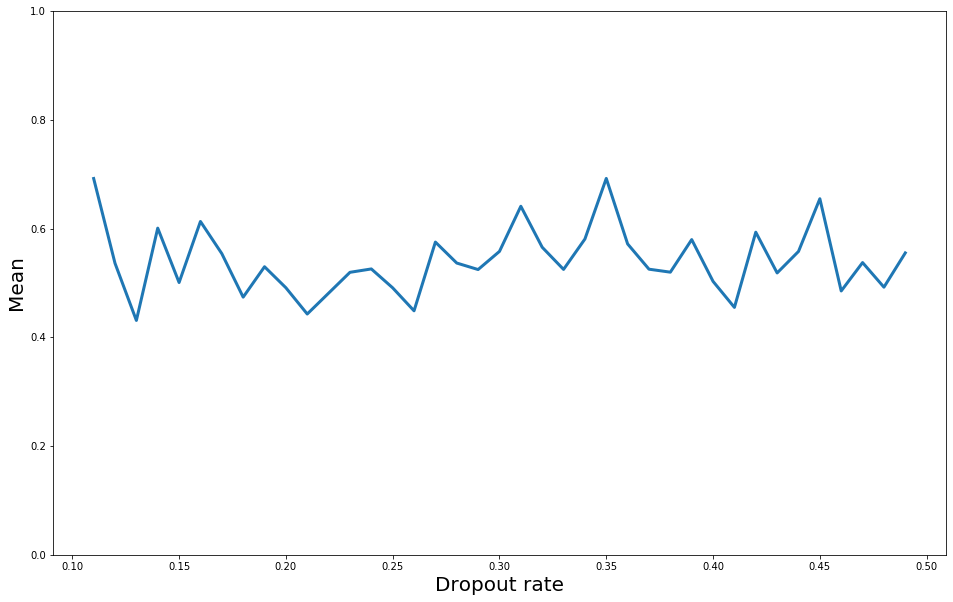

In [28]:
y_akses_list = []
counter = 0
print(new_values[:, 1])

for _ in range(11):
    y_akses_list.append(counter)
    counter += 0.05
plt.figure(figsize=(16, 10))

#plt.bar(, y_akses_list)
plt.ylim(0,1)
plt.xlabel('Dropout rate', fontsize=20)
plt.ylabel('Mean', fontsize=20)
#plt.tick_params(axis='both', which='major', labelsize=18)
plt.plot(new_values[:, 0].astype(np.float), new_values[:, 1].astype(np.float), linewidth=3)




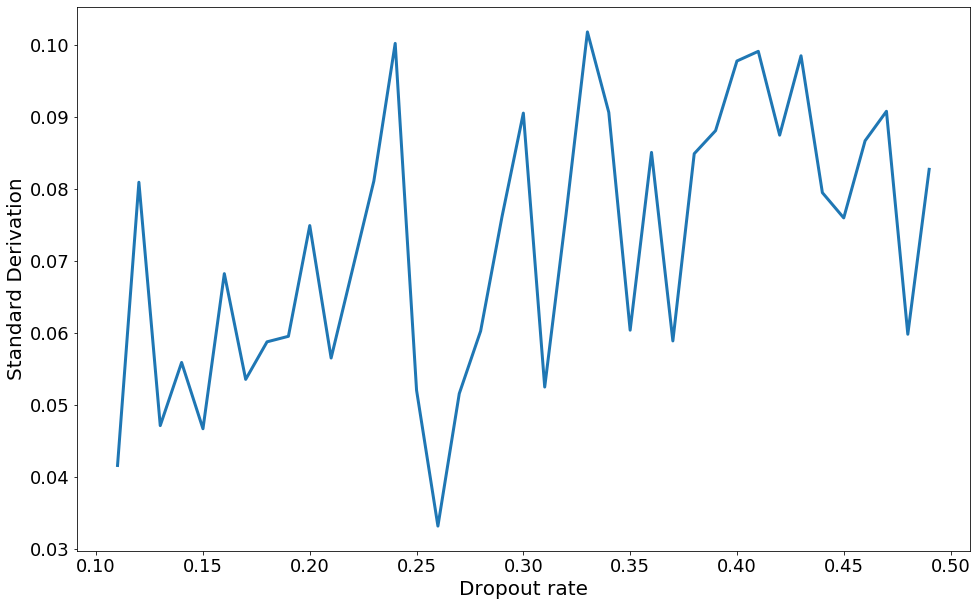

In [20]:
#dropout_list = name_dropout
plt.figure(figsize=(16, 10))

plt.xlabel('Dropout rate', fontsize=20)
plt.ylabel('Standard Derivation', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
#list(dropout_list)
plt.plot(new_values[:, 0].astype(np.float), new_values[:, 2].astype(np.float), linewidth=3)

In [ ]:
print(mean_list)

In [ ]:
print(std_list)